In [30]:
import tensorflow as tf
import numpy as np 
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Conv2D, MaxPooling2D
from keras.applications import (vgg16, ResNet50, densenet,
                                mobilenet_v2,
                                inception_resnet_v2,
                                inception_v3)





In [31]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
total_size = info.splits['train'].num_examples#Número total de ejemplos en el dataset

# División usando slices de TFDS (MÁS EFICIENTE)
train_split = 'train[:70%]'      # 70%
val_split = 'train[70%:85%]'     # 15%
test_split = 'train[85%:]'       # 15%

#Se cargan los datasets usando los splits definidos y devuelve tuplas (imagen, etiqueta)
train_dataset = tfds.load('tf_flowers', split=train_split, as_supervised=True)
validation_dataset = tfds.load('tf_flowers', split=val_split, as_supervised=True)
test_dataset = tfds.load('tf_flowers', split=test_split, as_supervised=True)

In [32]:
#CONFIGURACIÓN DE PARÁMETROS DE IMAGENES
bathchSize = 32
img_height = 180
img_width = 180
input_shape = (img_height, img_width, 3)
class_names = info.features['label'].names
print(class_names)
print(len(class_names))


['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


In [33]:
#Redimencionar imagenes
def preprocess(image, label):
    image = tf.image.resize(image, [img_height, img_width])
    return image, label

train_dataset = train_dataset.map(preprocess).batch(bathchSize).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess).batch(bathchSize).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(bathchSize).prefetch(buffer_size=tf.data.AUTOTUNE)

print("=== VERIFICACIÓN FINAL ===")
for images, labels in train_dataset.take(1):
    print(f"Batch de imágenes: {images.shape}")  # Debe ser (32, 224, 224, 3)
    print(f"Batch de labels: {labels.shape}")    # Debe ser (32,)
    print(f"Rango de píxeles: {images.numpy().min():.2f} - {images.numpy().max():.2f}")

=== VERIFICACIÓN FINAL ===
Batch de imágenes: (32, 180, 180, 3)
Batch de labels: (32,)
Rango de píxeles: 0.00 - 255.00


2025-12-28 22:29:28.123199: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [40]:
model = Sequential()

# Data augmentation + normalización
model.add(RandomFlip("horizontal", input_shape=input_shape))
model.add(RandomRotation(0.1))
model.add(RandomZoom(0.1))
model.add(Rescaling(1./255))

# Bloque convolucional 1
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

# Bloque convolucional 2
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

# Bloque convolucional 3
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))

# Clasificador
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))


/home/juan-jose/tf-gpu1/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
#Compilacion del modelo
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_7 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,031,813 (30.64 MB)

 Trainable params: 8,031,813 (30.64 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#Entrenamiento del modelo
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=100)
model.save("modelo_de_flower.h5")


Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.8560 - loss: 0.3860 - val_accuracy: 0.7459 - val_loss: 0.7496
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.8482 - loss: 0.3875 - val_accuracy: 0.7568 - val_loss: 0.7376
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8641 - loss: 0.3578 - val_accuracy: 0.7532 - val_loss: 0.8333
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.8614 - loss: 0.3791 - val_accuracy: 0.7641 - val_loss: 0.7286
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8661 - loss: 0.3652 - val_accuracy: 0.7495 - val_loss: 0.7746
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8466 - loss: 0.3756 - val_accuracy: 0.7568 - val_loss: 0.7396
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.8696 - loss: 0.3459 - val_accuracy: 0.7514 - val_loss: 0.7915
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.8875 - loss: 0.3116 - val_accuracy: 0.

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-12-28 22:57:40.947326: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


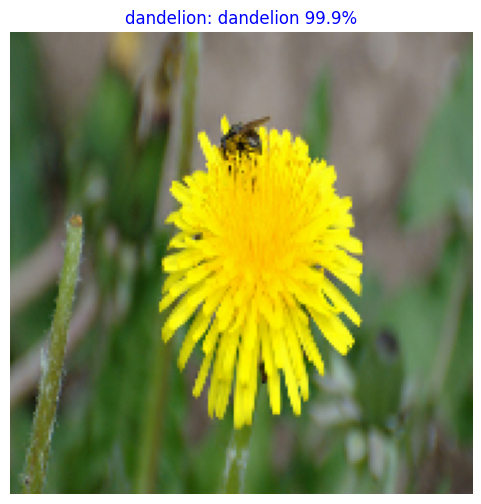

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


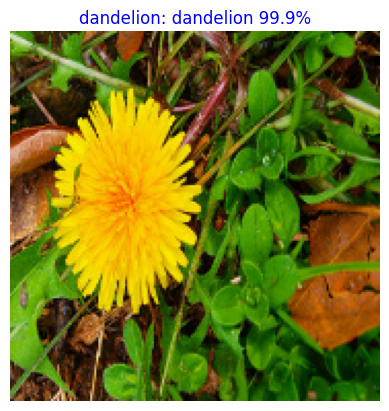

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


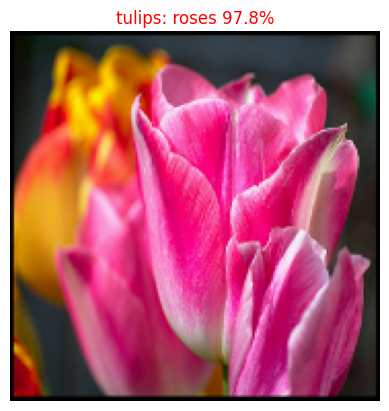

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


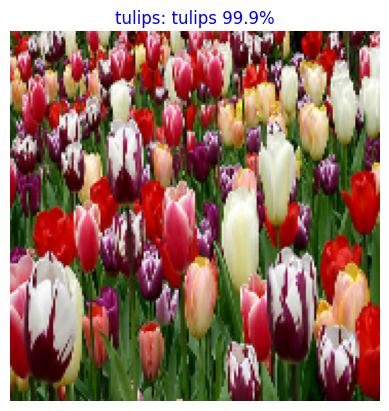

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


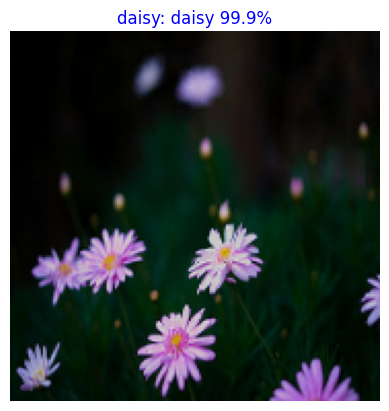

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


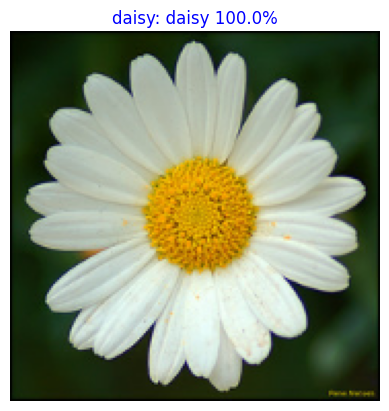

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


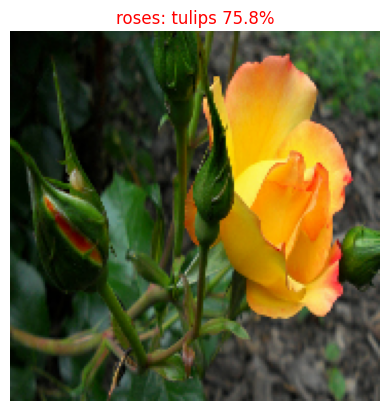

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


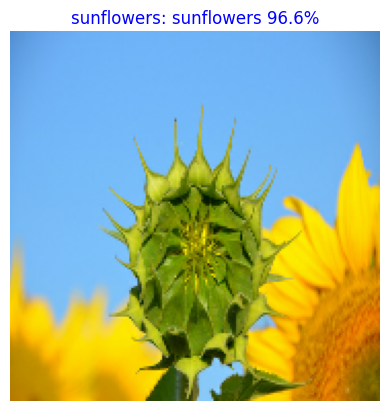

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


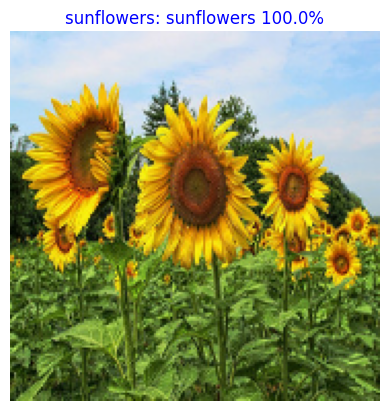

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


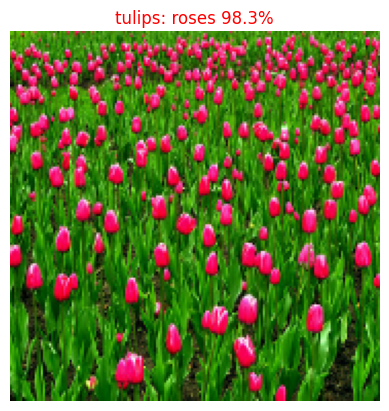

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


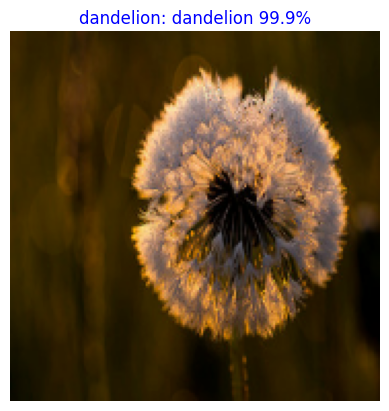

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


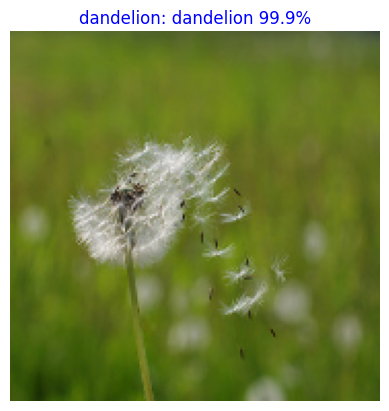

In [50]:
#Creacion de lotes de imagenes de prueba
#image_batch, label_batch = test_dataset.as_numpy_iterator().next()

image_batch, label_batch = test_dataset.as_numpy_iterator().next()

#Crea una figura de matplotlib
columns = 4
rows = 3
plt.figure(figsize=(15,6))

#Nombres de las clases
class_names = info.features['label'].names
#Esta funcion recorta un numero decimal sin redondear por ejemplo 92.678 → 92.6
#Esto con el fin de que las probabilidades sean legibles en las graficas
def truncate(number:float, max_decimals: int) -> float:
    int_part, dec_part = str(number).split(".")
    return float(f"{int_part}.{dec_part[:max_decimals]}")
    
#prediccion de las imagenes de prueba, se imprimen 9 imagenes de un lote
print(class_names)

#La prediccion aparece en el titulo de cada imagen
for i in range(1, columns*rows +1):
    imag_array = tf.expand_dims(image_batch[i], 0)#convierte (224,224,3) → (1,224,224,3), pues model.predict espera batch, asi sea de tamaño 1
    prediccions = model.predict(imag_array)#Se obtiene [[p_cat, p_dog]]
    if class_names[label_batch[i]] == class_names[np.argmax(prediccions)]:#np.argmax(prediccions) obtiene el indice de la clase con mayor probabilidad
        #Se compara el label del dataset con la prediccion del modelo

        color = 'blue'
    else:
        color = 'red'
    
    #Dibuja la imagen 
    plt.subplot
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("{}: {} {}%".format(class_names[label_batch[i]], class_names[np.argmax(prediccions)],
                                   truncate(100*np.max(prediccions),1)),color=color)#Pone la prediccion en el titulo
    plt.axis('off')
    plt.show()

[[1.0000000e+00 3.5024105e-13 2.1305722e-13 5.3348104e-19 1.5067624e-12]]
0
dandelion


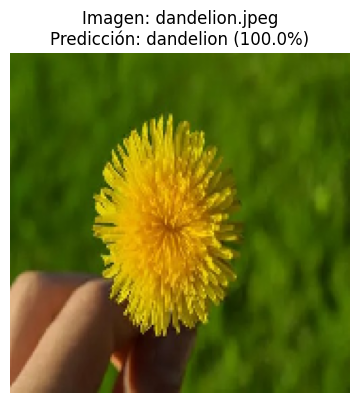

[[1.4320128e-05 2.5923265e-04 3.0487841e-02 1.2946160e-06 9.6923727e-01]]
4
roses


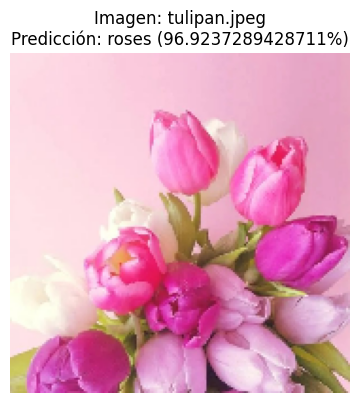

('roses',
 np.float32(96.92373),
 array([[1.4320128e-05, 2.5923265e-04, 3.0487841e-02, 1.2946160e-06,
         9.6923727e-01]], dtype=float32))

In [51]:
def predecirUNaImagen(ruta, modelo, class_names, img_size = (180,180)):
    #cargar la imagen y pasarla al modelo 
    img = tf.keras.utils.load_img(ruta, target_size=img_size)
    #Volver la imagen un arreglo numpy y expandir dimensiones para que el modelo la pueda procesar
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0) 
    # 5. Hacer predicción
    predicciones = modelo.predict(img_array, verbose=0)
    
    # 6. Interpretar resultados
    clase_idx = np.argmax(predicciones[0])# Indice de la clase con mayor probabilidad, se pone [0] pues es una matriz de 1 fila y una columna
    print(predicciones)
    print(clase_idx)
    confianza = np.max(predicciones[0]) * 100#Vuelve porcentaje la prediccion
    clase_nombre = class_names[clase_idx]#obtiene el nombre de la clase
    print(clase_nombre)    
    # 7. Mostrar resultados
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)#muestra la imagen
    plt.title(f"Imagen: {ruta.split('/')[-1]}\nPredicción: {clase_nombre} ({confianza}%)")#le pone titulo a la imagen
    plt.axis('off')
    
   # plt.subplot(1, 2, 2)
    
    plt.tight_layout()
    plt.show()

    
    return clase_nombre, confianza, predicciones

predecirUNaImagen('images/dandelion.jpeg'  , model, class_names) 
predecirUNaImagen('images/tulipan.jpeg'  , model, class_names)